# Grad-TTS: A Diffusion Probabilistic Model for Text-to-Speech

Official implementation of the Grad-TTS model based on Diffusion Probabilistic Models. For all details check out our paper accepted to ICML 2021 via [this](https://arxiv.org/abs/2105.06337) link.

You can listen to the demo samples via [this](https://grad-tts.github.io/) link.

**Authors**: Vadim Popov\*, Ivan Vovk\*, Vladimir Gogoryan, Tasnima Sadekova, Mikhail Kudinov.

\*Equal contribution.

**Note**: for fast synthesis prefer running inference on GPU device. Don't forget to change Colab runtime environment!

In [1]:
# Clone Grad-TTS repository
!npm install -g github-files-fetcher
!fetcher --url=https://github.com/huawei-noah/Speech-Backbones/tree/main/Grad-TTS

/tools/node/bin/fetcher -> /tools/node/lib/node_modules/github-files-fetcher/index.js
/tools/node/bin/github-files-fetcher -> /tools/node/lib/node_modules/github-files-fetcher/index.js
+ github-files-fetcher@1.6.0
added 1 package from 1 contributor in 0.472s

7fetcher |░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░| 0% || 0/0 File(s) || downloading... || authenticated: falsefetcher |░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░| 0% || 0/11 File(s) || downloading... || authenticated: falsefetcher |███████████████░░░░░░░░░░░░░░░░░░░░░░░░░| 36% || 4/11 File(s) || downloading... || authenticated: falsefetcher |██████████████████████████░░░░░░░░░░░░░░| 64% || 11/17 File(s) || downloading... || authenticated: falsefetcher |████████████████████████████░░░░░░░░░░░░| 70% || 12/17 File(s) || downloading... || authenticated: falsefetcher |████████████████████████████████████░░░░| 89% || 17/19 File(s) || downloading... || authenticated: falsefetcher |██████████████████████████████████░░░░░░| 85% || 17/20 Fi

In [39]:
# Install dependencies
!pip install -r Grad-TTS/requirements.txt
# restart runtime environment if asks and run this cell and the previous one once again
# also if you have plotting errors during synthesis, also restart the environment and recompile all cells

In [40]:
# Build Monotonic Alignment Search code (Cython)
!cd Grad-TTS/model/monotonic_align; mkdir -p model/monotonic_align; python setup.py build_ext --inplace

In [41]:
# Download pre-trained models (HiFi-GAN, Grad-TTS and Grad-TTS Old Version)
!git clone https://github.com/circulosmeos/gdown.pl
!cd Grad-TTS/checkpts/; \
  ../../gdown.pl/gdown.pl 'https://drive.google.com/file/d/15AeZO2Zo4NBl7PG8oGgfQk0J1PpjaOgI' hifigan.pt; \
  ../../gdown.pl/gdown.pl 'https://drive.google.com/file/d/1YrlswCD2Q_IUlvFtQQ-gnfkG7FEvRoPJ' grad-tts.pt; \
  ../../gdown.pl/gdown.pl 'https://drive.google.com/file/d/1EAo_iOblkc9hbQf153lYyIXYSiN1MfO3' grad-tts-old.pt; \
  ../../gdown.pl/gdown.pl 'https://drive.google.com/file/d/14JxcJJ4_t3p38YI2LPDXcinauk76Lj4g' grad-tts-libri-tts.pt

fatal: destination path 'gdown.pl' already exists and is not an empty directory.
--2024-02-03 23:16:10--  https://docs.google.com/uc?id=15AeZO2Zo4NBl7PG8oGgfQk0J1PpjaOgI&export=download
Resolving docs.google.com (docs.google.com)... 142.251.2.138, 142.251.2.101, 142.251.2.139, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=15AeZO2Zo4NBl7PG8oGgfQk0J1PpjaOgI&export=download [following]
--2024-02-03 23:16:11--  https://drive.usercontent.google.com/download?id=15AeZO2Zo4NBl7PG8oGgfQk0J1PpjaOgI&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 416 Requested range not satisfiable

    The file is already fully retrieved; no

In [42]:
import argparse
import json
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from scipy.io.wavfile import write

import torch

# For Grad-TTS
import sys
sys.path.append('Grad-TTS/')
import params
from model import GradTTS
from text import text_to_sequence, cmudict
from text.symbols import symbols
from utils import intersperse

# For HiFi-GAN
sys.path.append('Grad-TTS/hifi-gan/')
from env import AttrDict
from models import Generator as HiFiGAN

Initialize Grad-TTS feature generator:

In [7]:
N_SPKS = 247  # 247 for Libri-TTS checkpoint and 1 for LJSpeech single speaker checkpoint

In [51]:
# Note: besides Libri-TTS checkpoint we open-source 2 LJSpeech checkpoints of Grad-TTS.
# These 2 are the same models but trained with different positional encoding scale:
#   * x1 ("grad-tts-old.pt", ICML 2021 sumbission model)
#   * x1000 ("grad-tts.pt")
# To use the former set Grad-TTS argument pe_scale=1 and to use the latter set pe_scale=1000.
# To use Libri-TTS checkpoint use pe_scale=1000.

generator = GradTTS(len(symbols)+1, N_SPKS, params.spk_emb_dim, params.n_enc_channels, params.filter_channels,
                    params.filter_channels_dp, params.n_heads, params.n_enc_layers,
                    params.enc_kernel, params.enc_dropout, params.window_size,
                    params.n_feats, params.dec_dim, params.beta_min, params.beta_max,
                    pe_scale=1)  # pe_scale=1 for `grad-tts-old.pt`

model_path = "./Grad-TTS/checkpts/grad-tts-libri-tts.pt"
# model_path = "./Grad-TTS/checkpts/grad-tts-old.pt"
# model_path = "./Grad-TTS/checkpts/grad-tts.pt"

torch.save(generator.state_dict(), model_path)
generator.load_state_dict(torch.load(model_path, map_location='cpu'))
# generator.load_state_dict(torch.load(model_path, map_location=lambda loc, storage: loc))
_ = generator.cuda().eval()
print(f'Number of encoder parameters: {generator.encoder.nparams}')
print(f'Number of decoder parameters: {generator.decoder.nparams}')
print(f'Number of total parameters: {generator.nparams}')

cmu = cmudict.CMUDict('./Grad-TTS/resources/cmu_dictionary')
cmu

Number of encoder parameters: 7200145
Number of decoder parameters: 7672727
Number of total parameters: 14888680


Initialize HiFi-GAN vocoder:

In [52]:
with open('./Grad-TTS/checkpts/hifigan-config.json') as f:
    h = AttrDict(json.load(f))
hifigan = HiFiGAN(h)
hifigan.load_state_dict(torch.load('./Grad-TTS/checkpts/hifigan.pt',
                                   map_location=lambda loc, storage: loc)['generator'])
_ = hifigan.cuda().eval()
hifigan.remove_weight_norm()
%matplotlib inline

Removing weight norm...


Prepare input text:

In [53]:
text = "Here are the match lineups for the Colombia Haiti match."

In [54]:
x = torch.LongTensor(intersperse(text_to_sequence(text, dictionary=cmu), len(symbols))).cuda()[None]
x_lengths = torch.LongTensor([x.shape[-1]]).cuda()
x.shape, x_lengths

(torch.Size([1, 97]), tensor([97], device='cuda:0'))

Predict mel-spectrogram:

In [55]:
SPEAKER_ID = 15  # set speaker id if you are using multi-speaker model, ignore otherwise

Grad-TTS RTF: 0.09000111970248287


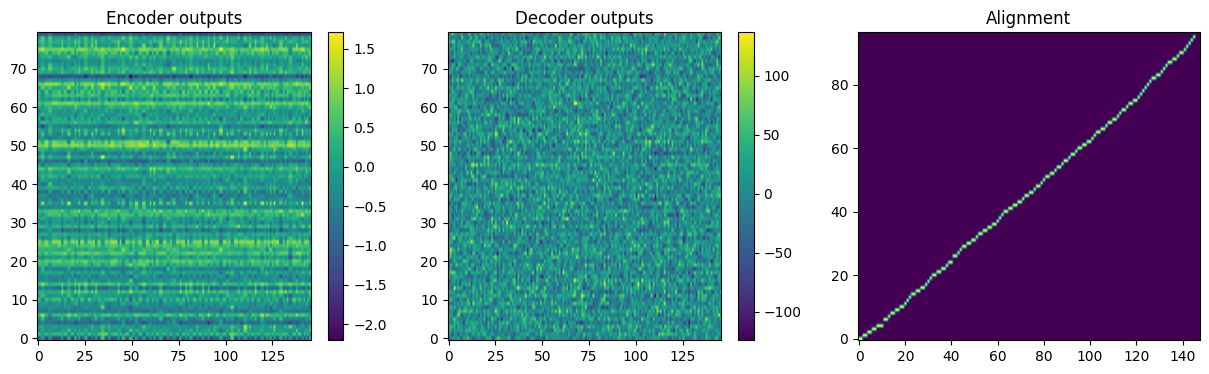

In [56]:
t = dt.datetime.now()
y_enc, y_dec, attn = generator.forward(x, x_lengths, n_timesteps=10, temperature=1.5,
                                       stoc=False, spk=torch.LongTensor([SPEAKER_ID]).cuda() if N_SPKS > 1 else None,
                                       length_scale=0.91)
t = (dt.datetime.now() - t).total_seconds()
print(f'Grad-TTS RTF: {t * 22050 / (y_dec.shape[-1] * 256)}')

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title('Encoder outputs')
plt.imshow(y_enc.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title('Decoder outputs')
plt.imshow(y_dec.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title('Alignment')
plt.imshow(attn.cpu().squeeze(), aspect='auto', origin='lower');

Restore raw waveform:

In [57]:
with torch.no_grad():
    audio = hifigan.forward(y_dec).cpu().squeeze().clamp(-1, 1)
ipd.display(ipd.Audio(audio, rate=22050))

In [31]:
# !python ./Grad-TTS/train.py